# Baker yeast experiment with 4 parameters - version 0

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/ingar-pub%2Fbiolab/master?filepath=%2Fbiolab%2Fby4%2Fdo_mpc_v0.ipynb)

do_mpc implementation of experiment simulation.

First, we start with importing modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from casadi.tools import *
import pdb
import sys
sys.path.append('../../')
import do_mpc

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

""" User settings: """
show_animation = True
store_results = False

## Model definition

The considered model is continuous and has 2 states, 2 control inputs and 4 parameters. The model is initiated by:

In [2]:
"""
do-mpc model definition
"""
def build_model():
    """
    --------------------------------------------------------------------------
    template_model: Variables / RHS / AUX
    --------------------------------------------------------------------------
    """
    model_type = 'continuous' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Certain parameters
    # theta = [0.5, 0.5, 0.5, 0.5]
    # th0 = 0.5
    # th1 = 0.5
    # th2 = 0.5
    # th3 = 0.5
    # mu_m  = 0.02

    # States struct (optimization variables):
    X0_s = model.set_variable('_x',  'X0_s') # X0_s biomass concentration, g/l. Ref: 1 - 10 g/l.
    X1_s = model.set_variable('_x',  'X1_s') # X1_s substrate concentration, g/l. Ref: 0.1 g/l. Initial 0.1

    # Input struct (optimization variables):
    u0 = model.set_variable('_u',  'u0') # inp1: dilution factor h-1. Ref: 0.05 - 0.20 h-10.
    u1 = model.set_variable('_u',  'u1') # inp2: substrate concentration in the feed g/l. Ref: 5 - 35 g/l

    # Fixed parameters:
    # Y_x = model.set_variable('_p',  'Y_x')
    # S_in = model.set_variable('_p', 'S_in')

    # Uncertain parameters:
    th0 = model.set_variable('_p', 'th0')
    th1 = model.set_variable('_p', 'th1')
    th2 = model.set_variable('_p', 'th2')
    th3 = model.set_variable('_p', 'th3')

    # Auxiliary term
    r = th0 * X1_s / (th1 + X1_s)

    # Differential equations
    model.set_rhs('X0_s', (r - u0 - th3) * X0_s)
    model.set_rhs('X1_s', (r * X0_s / th2) + u0 * (u1 - X1_s))

    # Build the model
    model.setup()

    return model

## Controller

Next, the model predictive controller is configured.


In [3]:
"""
do-mpc controller mpc definition
"""
def build_mpc(model):
    """
    --------------------------------------------------------------------------
    template_mpc: tuning parameters
    --------------------------------------------------------------------------
    """
    mpc = do_mpc.controller.MPC(model)

    setup_mpc = {
        'n_horizon': 20,
        'n_robust': 1,
        'open_loop': 0,
        't_step': 1.0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
        # Use MA27 linear solver in ipopt for faster calculations:
        #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
    }

    mpc.set_param(**setup_mpc)

    mterm = -model.x['X0_s'] # stage cost
    lterm = -model.x['X0_s'] # terminal cost

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u0=1.0, u1=1.0) # penalty on input changes

    # Constraints
    # lower bounds of the states
    mpc.bounds['lower', '_x', 'X0_s'] = 0.0
    mpc.bounds['lower', '_x', 'X1_s'] = 0.0

    # upper bounds of the states
    # mpc.bounds['upper', '_x','X0_s'] = 3.7
    # mpc.bounds['upper', '_x','X1_s'] = 3.0

    # upper and lower bounds of the control input
    mpc.bounds['lower','_u','u0'] = 0.05
    mpc.bounds['upper','_u','u0'] = 0.20
    mpc.bounds['lower','_u','u1'] = 5
    mpc.bounds['upper','_u','u1'] = 35

    # Uncertain values
    th0_values = np.array([0.5, 0.4, 0.3])
    th1_values = np.array([0.5, 0.4, 0.3])
    th2_values = np.array([0.5, 0.4, 0.3])
    th3_values = np.array([0.5, 0.4, 0.3])

    mpc.set_uncertainty_values(
        th0 = th0_values, 
        th1 = th1_values, 
        th2 = th2_values, 
        th3 = th3_values
    )

    mpc.setup()

    return mpc

## Simulator

In order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator.

In [4]:
"""
do-mpc simulator mpc definition
"""
def build_simulator(model):
    """
    --------------------------------------------------------------------------
    template_simulator: tuning parameters
    --------------------------------------------------------------------------
    """
    simulator = do_mpc.simulator.Simulator(model)

    params_simulator = {
        'integration_tool': 'cvodes',
        'abstol': 1e-10,
        'reltol': 1e-10,
        't_step': 1.0
    }

    simulator.set_param(**params_simulator)

    # Realizations of uncertain parameters
    p_num = simulator.get_p_template()
    p_num['th0'] = 0.5
    p_num['th1'] = 0.5
    p_num['th2'] = 0.5
    p_num['th3'] = 0.5

    def p_fun(t_now):
        return p_num

    simulator.set_p_fun(p_fun)

    simulator.setup()

    return simulator


## Modules assembly & estimator define

In [5]:
"""
Get configured do-mpc modules
"""
model = build_model()
mpc = build_mpc(model)
simulator = build_simulator(model)
estimator = do_mpc.estimator.StateFeedback(model)

## Closed-loop simulation

We define the initial state of the system and set it for all parts of the closed-loop configuration. After that, we simulate the closed-loop for 50 steps (and suppress the output of the cell with the magic command `%%capture`)

In [6]:
%%capture
"""
Set initial state
"""
X0_s_0 = 5.5 # Concentration biomass [g/l]
X1_s_0 = 0.1 # Concentration substrate [g/l]

x0 = np.array([X0_s_0, X1_s_0])

# Set for controller, simulator and estimator
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()
for k in range(50):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

## Visualization of results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object.
Configure matplotlib.

Writing frame: 0.Writing frame: 1.Writing frame: 2.Writing frame: 3.Writing frame: 4.Writing frame: 5.Writing frame: 6.Writing frame: 7.Writing frame: 8.Writing frame: 9.Writing frame: 10.Writing frame: 11.Writing frame: 12.Writing frame: 13.Writing frame: 14.Writing frame: 15.Writing frame: 16.Writing frame: 17.Writing frame: 18.Writing frame: 19.Writing frame: 20.Writing frame: 21.Writing frame: 22.Writing frame: 23.Writing frame: 24.Writing frame: 25.Writing frame: 26.Writing frame: 27.Writing frame: 28.Writing frame: 29.Writing frame: 30.Writing frame: 31.Writing frame: 32.Writing frame: 33.Writing frame: 34.Writing frame: 35.Writing frame: 36.Writing frame: 37.Writing frame: 38.Writing frame: 39.Writing frame: 40.Writing frame: 41.Writing frame: 42.Writing frame: 43.Writing frame: 44.Writing frame: 45.Writing frame: 46.Writing frame: 47.Writing frame: 48.Writing frame: 49.

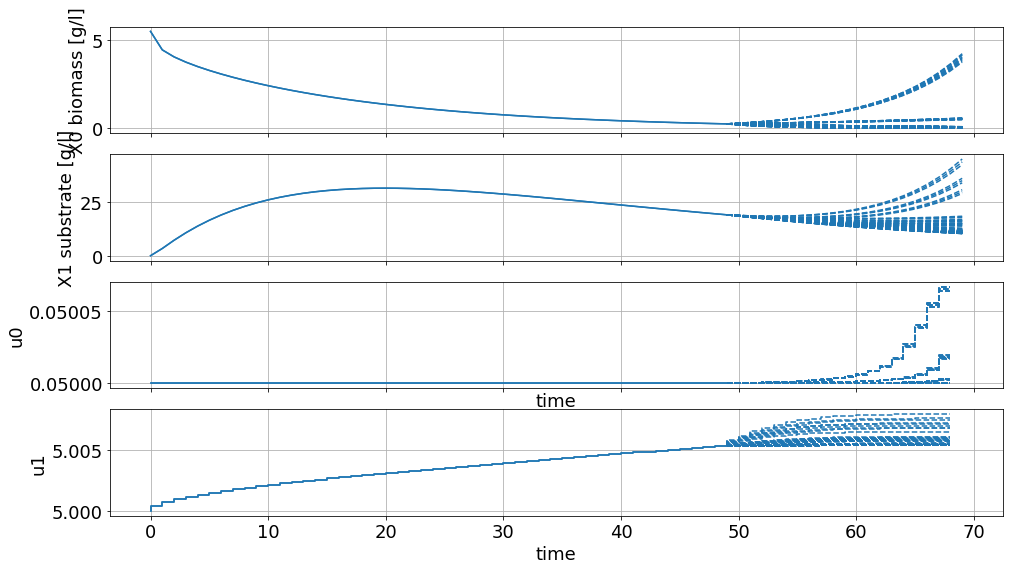

In [7]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# matplotlib config
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

fig, ax = plt.subplots(4, sharex=True, figsize=(16,9))
# Configure plot:
for g in [sim_graphics,mpc_graphics]:
    # Plot the state on axis 1 & 2:
    g.add_line(var_type='_x', var_name='X0_s', axis=ax[0], color='#1f77b4')
    g.add_line(var_type='_x', var_name='X1_s', axis=ax[1], color='#1f77b4')
    # Plot the control input 3 & 4:
    g.add_line(var_type='_u', var_name='u0', axis=ax[2], color='#1f77b4')
    g.add_line(var_type='_u', var_name='u1', axis=ax[3], color='#1f77b4')

ax[0].set_ylabel('X0 biomass [g/l]')
ax[1].set_ylabel('X1 substrate [g/l]')
ax[2].set_ylabel('u0')
ax[2].set_xlabel('time')
ax[3].set_ylabel('u1')
ax[3].set_xlabel('time')

from matplotlib.animation import FuncAnimation, ImageMagickWriter

# function to make animation
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('do_mpc_v0.gif', writer=gif_writer)